# Insights from 2018 Stackoverflow developer survey 

In [6]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
sns.set(style="ticks")
import copy
from scipy import stats

import plotly
import plotly.graph_objs as go

plotly.offline.init_notebook_mode(connected=True)

## Load data

1. Load the public survey results dataset from 2018
2. Parse data and attribute a developer role using the following criteria:
    - When "developer" is in the DevType column, it is considered a developer, otherwise it's not one. For example: 
      - For "Engineering manager" we set `IsDeveloper = false`
      - For "Front-end developer" we set `IsDeveloper = true`

In [12]:
data = pd.read_csv("survey_results_public.csv", low_memory=False)
data['IsDeveloper'] = data.DevType.str.contains('developer')
data.head()

,Respondent,Hobby,OpenSource,Country,Student,Employment,FormalEducation,UndergradMajor,CompanySize,DevType,...,Gender,SexualOrientation,EducationParents,RaceEthnicity,Age,Dependents,MilitaryUS,SurveyTooLong,SurveyEasy,IsDeveloper
0,1,Yes,No,Kenya,No,Employed part-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Mathematics or statistics,20 to 99 employees,Full-stack developer,...,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",Black or of African descent,25 - 34 years old,Yes,NaN,The survey was an appropriate length,Very easy,True
1,3,Yes,Yes,United Kingdom,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","A natural science (ex. biology, chemistry, phy...","10,000 or more employees",Database administrator;DevOps specialist;Full-...,...,Male,Straight or heterosexual,"Bachelor’s degree (BA, BS, B.Eng., etc.)",White or of European descent,35 - 44 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy,True
2,4,Yes,Yes,United States,No,Employed full-time,Associate degree,"Computer science, computer engineering, or sof...",20 to 99 employees,Engineering manager;Full-stack developer,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,True
3,5,No,No,United States,No,Employed full-time,"Bachelor’s degree (BA, BS, B.Eng., etc.)","Computer science, computer engineering, or sof...",100 to 499 employees,Full-stack developer,...,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,35 - 44 years old,No,No,The survey was an appropriate length,Somewhat easy,True
4,7,Yes,No,South Africa,"Yes, part-time",Employed full-time,Some college/university study without earning ...,"Computer science, computer engineering, or sof...","10,000 or more employees",Data or business analyst;Desktop or enterprise...,...,Male,Straight or heterosexual,Some college/university study without earning ...,White or of European descent,18 - 24 years old,Yes,NaN,The survey was an appropriate length,Somewhat easy,True


## Extract insights

The goal of this analysis is to extract general insights from this dataset. In the next sections, we explore the survey results to answer the following business questions:

#### Turn-over factors
    - Are developers predominantly active job seekers or not? 

#### Impact of programming language
    - Are functional language developers happier than non-functional ones?

#### Compensation x Satisfaction
    - What is the salary level after which money doesn't make a difference in terms of job satisfaction? 

#### Wellness 
    - Do developers who exercise are happier and more productive than developers who don’t exercise?

### Q1. Are Latin American developers predominantly active job seekers or not? 
We restricted the analysis to the following countries: Brazil, Argentina, Uruguay, Paraguay, Bolivia, Peru, Colombia, Venezuela, Bolivia, Suriname, Guyana, French Guiana

In [13]:
countries = ['Brazil','Argentina','Uruguay','Paraguay','Bolivia','Peru','Colombia', 
             'Venezuela, Bolivarian Republic of...','Suriname','Guyana','French Guiana']


In [14]:
# Getting total developers, total active job seekers and active job seekers rate for each country.
data_country = data[((data.IsDeveloper == True) &
                    (data.Country.isin(countries)) & 
                    (data.JobSearchStatus.notnull()))]

total = data_country.Country.value_counts()
total = total.rename_axis('Country').reset_index(name='TotalDevelopers')

active_jobseekers = data_country[data_country.JobSearchStatus == 'I am actively looking for a job'].Country.value_counts()
active_jobseekers = active_jobseekers.rename_axis('Country').reset_index(name='ActiveJobseekers')

result = pd.merge(total, active_jobseekers,on='Country', how='outer').fillna(0)
result['ActiveJobseekersRate'] = round(result.ActiveJobseekers / result.TotalDevelopers,2)
result = result.sort_values('ActiveJobseekersRate', ascending=False)
result 

,Country,TotalDevelopers,ActiveJobseekers,ActiveJobseekersRate
3,"Venezuela, Bolivarian Republic of...",93,34.0,0.37
4,Peru,83,27.0,0.33
6,Paraguay,37,12.0,0.32
2,Colombia,260,68.0,0.26
0,Brazil,1829,339.0,0.19
7,Bolivia,29,5.0,0.17
1,Argentina,468,59.0,0.13
5,Uruguay,75,5.0,0.07
8,Guyana,2,0.0,0.00
9,Suriname,1,0.0,0.00


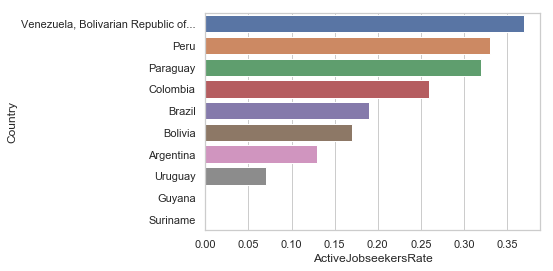

In [442]:
sns.set(style="whitegrid")
ax = sns.barplot(x="ActiveJobseekersRate", y="Country", data=result)
plt.show()

It seems Latin developers are not predominantly active job seekers. The Top5 rank by country suggests the following distribution:
- Peru (33%)
- Paraguay (32%)
- Colombia (26%)
- Brazil (19%)
- Argentina (15%)

Mostly of the developers for these country are NOT actively looking for new jobs. Are they satisfied with their current jobs? It's something we try to answer in the next analysis.

### Q2. Are people writing code in functional languages happier compared to non-functional developers?

In this analysis, we define a functional developer as someone coding primarly in Erlang, Haskell, Lisp, Scheme, Clojure or Scala. Are developers coding in this stack happier than others?

In [15]:
func_languages = ['Erlang', 'Haskell', 'Lisp', 'Scheme', 'Clojure', 'Scala']

data_fl = copy.deepcopy(data)
data_fl['IsFunctional'] = data.LanguageWorkedWith.str.contains('|'.join(func_languages))

data_fl[['LanguageWorkedWith', 'IsFunctional']].head(10)

,LanguageWorkedWith,IsFunctional
0,JavaScript;Python;HTML;CSS,False
1,JavaScript;Python;Bash/Shell,False
2,NaN,NaN
3,C#;JavaScript;SQL;TypeScript;HTML;CSS;Bash/Shell,False
4,C;C++;Java;Matlab;R;SQL;Bash/Shell,False
5,Java;JavaScript;Python;TypeScript;HTML;CSS,False
6,JavaScript;HTML;CSS,False
7,JavaScript;TypeScript;HTML;CSS,False
8,Assembly;CoffeeScript;Erlang;Go;JavaScript;Lua...,True
9,NaN,NaN


In [16]:
# Removing null values and who has never had a job.
data_fl = data_fl[(data_fl.LanguageWorkedWith.notnull()) & 
                  (data_fl.LastNewJob.notnull()) & 
                  (data_fl.LastNewJob != "I've never had a job") &
                  (data_fl.JobSatisfaction.notnull()) &
                  (data_fl.IsDeveloper.notnull())]

data_fl.JobSatisfaction.unique()

array(['Extremely satisfied', 'Moderately dissatisfied',
       'Neither satisfied nor dissatisfied', 'Slightly satisfied',
       'Moderately satisfied', 'Slightly dissatisfied',
       'Extremely dissatisfied'], dtype=object)

In [17]:
# Mapping JobSatisfaction values into the 1-7 scale, from the most dissatisfied to the most satisfied:

job_satisfaction_score = {'Extremely dissatisfied': 1, 
                          'Moderately dissatisfied': 2, 
                          'Slightly dissatisfied': 3,
                          'Neither satisfied nor dissatisfied': 4, 
                          'Slightly satisfied': 5, 
                          'Moderately satisfied': 6,
                          'Extremely satisfied':7}

data_fl['JobSatisfactionScore'] = data_fl.JobSatisfaction.map(job_satisfaction_score)

data_fl[['JobSatisfaction', 'JobSatisfactionScore']].head()

,JobSatisfaction,JobSatisfactionScore
0,Extremely satisfied,7
1,Moderately dissatisfied,2
3,Neither satisfied nor dissatisfied,4
4,Slightly satisfied,5
5,Moderately satisfied,6


In [450]:
# Functional developers distribution
func_group = data_fl[(data_fl.IsFunctional == True)]
func_group.JobSatisfactionScore.describe()

count    5011.000000
mean        5.092796
std         1.747530
min         1.000000
25%         4.000000
50%         6.000000
75%         6.000000
max         7.000000
Name: JobSatisfactionScore, dtype: float64

In [452]:
# Non-Functional developers distribution
non_func_group = data_fl[(data_fl.IsFunctional == False) & 
                          (data_fl.IsDeveloper == True)]
non_func_group.JobSatisfactionScore.describe()

count    52085.000000
mean         5.039973
std          1.717450
min          1.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: JobSatisfactionScore, dtype: float64

### Hypothesis Test

Which group is better ? In the code below we run a t-test to get these results

H0: people coding in functional languages (not necessary a developer) are happier?

In [454]:
stats.ttest_ind(func_group.JobSatisfactionScore,non_func_group.JobSatisfactionScore, equal_var = False)

Ttest_indResult(statistic=2.0467425297689688, pvalue=0.04072699873371087)

> As the t-statistic (2.046) > critical value (1.96) and pvalue (0.040) < significance level (0.05), we reject the null hypothesis that the means are equal. So, the groups are different statistically. Thus, we can confirm people who writing code in functional languages (not necessary a developer) are happier than non-functional developers.

Let's also check another hypothesis:

H0: people coding in functional languages (not necessary a developer) AND are DEVELOPERS are happier?

In [456]:
func_group = func_group[func_group.IsDeveloper == True]
stats.ttest_ind(func_group.JobSatisfactionScore,non_func_group.JobSatisfactionScore, equal_var = False)

Ttest_indResult(statistic=1.5000426957157555, pvalue=0.13366091415850037)

> if we consider only functional and non-functional developers, we can confirm the groups are NOT different statistically (|t| < 1.96 and pvalue > 0.05).

### Q3. What is the salary level after which money doesn't make a difference in terms of job satisfaction? 

### Data normalization

We don't need to any normalization as `ConvertedSalary` attribute is already normalised (Salary converted to annual USD salaries using the exchange rate on 2018-01-18, assuming 12 working months and 50 working weeks).

In [18]:
# Removing null values, who has never had a job and 0 values for salary.
data_s = copy.deepcopy(data[(data.JobSatisfaction.notnull()) & 
                            (data.ConvertedSalary.notnull()) &
                            (data.ConvertedSalary > 0) &
                            (data.LastNewJob.notnull()) &
                            (data.LastNewJob != "I've never had a job")])


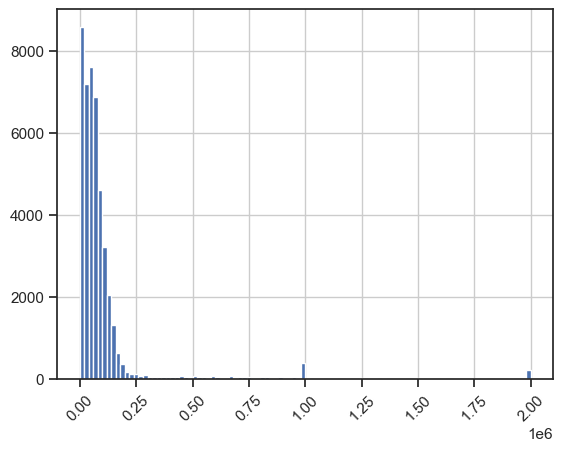

In [10]:
# Salary Distribution
data_s.ConvertedSalary.hist(bins=100)
plt.xticks(rotation=45)
plt.show()

In [19]:
data_s['JobSatisfactionScore'] = data_s.JobSatisfaction.map(job_satisfaction_score)
data_s[['ConvertedSalary', 'JobSatisfaction', 'JobSatisfactionScore']].head()

,ConvertedSalary,JobSatisfaction,JobSatisfactionScore
1,70841.0,Moderately dissatisfied,2
4,21426.0,Slightly satisfied,5
5,41671.0,Moderately satisfied,6
6,120000.0,Slightly satisfied,5
8,250000.0,Moderately satisfied,6


In [463]:
# Removing salaries > 250000 because the most salaries is lower than this value.
# Creating a boxplot: JobSatisfactionScore vs ConvertedSalary

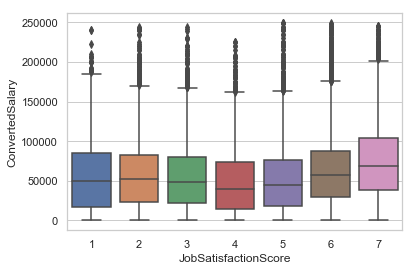

In [464]:
data_s = data_s[data_s.ConvertedSalary < 250000]
ax = sns.boxplot(data_s.JobSatisfactionScore, data_s.ConvertedSalary)
plt.show()

In [20]:
data_s.groupby(['JobSatisfactionScore'])['ConvertedSalary'].median().values

array([50000., 51983., 48313., 40261., 44504., 57276., 69192.])

> Here, it seems higher salaries mean higher satisfaction. As you can see in score 6 (Moderately satisfied) and score 7 (Extremely satisfied), they have the highest medians, around 57k and 69k respectively.
Although, after around 200k (max value of score 7 without outliers), we can say the job satisfaction has no longer influence in the salary anymore.

In [466]:
# Mapping ConvertedSalary values into 10 ranges of salary, from 0k-25k to 225k-250k

In [21]:
nbins = 10
data_s['ConvertedSalaryRange'] = pd.cut(data_s['ConvertedSalary'], 
                                        bins=nbins, 
                                        labels=False) 
labels = np.array(['0k-25k', '25k-50k', '50k-75k', '75k-100k', '100k-125k', '125k-150k', '150k-175k', '175k-200k', '200k-225k', '225k-250k'])

data_s['ConvertedSalaryLabel'] = labels[data_s['ConvertedSalaryRange']]

data_s[['ConvertedSalary', 'ConvertedSalaryRange', 'ConvertedSalaryLabel', 'JobSatisfactionScore']].head()

,ConvertedSalary,ConvertedSalaryRange,ConvertedSalaryLabel,JobSatisfactionScore
1,70841.0,2,50k-75k,2
4,21426.0,0,0k-25k,5
5,41671.0,1,25k-50k,6
6,120000.0,4,100k-125k,5
17,47904.0,1,25k-50k,6


### Other visualizaitons: a stacked bar chart 

In [36]:
distributions = {}
color_map = { 1: '#762a83', 2: '#af8dc3', 3: '#e7d4e8', 4: '#f7f7f7', 5: '#d9f0d3', 6: '#7fbf7b', 7: '#1b7837'}

data_df = copy.deepcopy(data_s)

# create each bin (stacked bar)
for i in range(0, nbins):
    df = data_df[(data_df['ConvertedSalaryRange'] == i)]
    
    # loop over the JobSatisfactionScore values
    for j in range(1, 8):
        if j not in distributions:
            distributions[j] = []
        
        # Calculate percentage
        partial = df[(df['JobSatisfactionScore'] == j)].count()['JobSatisfactionScore']    
        total = df.count()['JobSatisfactionScore']    
         
        distributions[j].append(partial/total)

# Build the chart      
res = []
for k,v in distributions.items():  
    trace = go.Bar(
        x=labels,
        y=[x*100 for x in v],
        name=str(k),
        marker=dict(color=color_map[k])
    )

    res.append(trace)
    
layout = go.Layout(
    barmode='stack',
    xaxis=dict(title='Salary Range'),
    yaxis=dict(title='% of Respondents')
)

fig = go.Figure(data=res, layout=layout)
#plotly.offline.iplot(fig)


![My Image](fig/chart.png)


>Here, you can see the distribution (percentage of respondents) of JobSatisfationScore per salary range. Like the previous box-plot, we can notice the higher salaries mean higher satisfaction (growth of score 7). Although, after the range of 175k-200k, so after 200k, the percentage of people who pick the score 7 (Extremely satisfied) started to decrease which suggests that salary increase stopped increasing job statisfaction.

### Q4. Do developers who exercise are happier and more productive than developers who don’t exercise? 

In [471]:
# Removing null values and who has never had a job.
data_dev = copy.deepcopy(data[(data.IsDeveloper == True) &
                        (data.Exercise.notnull()) & 
                        (data.JobSatisfaction.notnull()) & 
                        (data.LastNewJob.notnull()) & 
                        (data.LastNewJob != "I've never had a job")])

data_dev['JobSatisfactionScore'] = data_dev.JobSatisfaction.map(job_satisfaction_score)


In [472]:
data_dev[['Exercise', 'JobSatisfaction', 'JobSatisfactionScore']].head()

,Exercise,JobSatisfaction,JobSatisfactionScore
0,3 - 4 times per week,Extremely satisfied,7
1,Daily or almost every day,Moderately dissatisfied,2
3,I don't typically exercise,Neither satisfied nor dissatisfied,4
4,3 - 4 times per week,Slightly satisfied,5
5,1 - 2 times per week,Moderately satisfied,6


In [473]:
# developers who exercise

In [474]:
exercise_group = data_dev[data_dev.Exercise != "I don't typically exercise"]
exercise_group.JobSatisfactionScore.describe()

count    35105.000000
mean         5.088477
std          1.711479
min          1.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: JobSatisfactionScore, dtype: float64

In [475]:
# developers who don't exercise

In [476]:
non_exercise_group = data_dev[data_dev.Exercise == "I don't typically exercise"]
non_exercise_group.JobSatisfactionScore.describe()

count    20919.000000
mean         4.978823
std          1.725713
min          1.000000
25%          4.000000
50%          6.000000
75%          6.000000
max          7.000000
Name: JobSatisfactionScore, dtype: float64

In [477]:
# Hypothesis Test:

In [478]:
stats.ttest_ind(exercise_group.JobSatisfactionScore,non_exercise_group.JobSatisfactionScore, equal_var = False)

Ttest_indResult(statistic=7.297284566109107, pvalue=2.9861388165588865e-13)

> Developers who exercise are not happier than developers who don't exercise. The groups are NOT different statiscally (pvalue > 0.05).

#### Using ` SkipMeals` as a productivity indicator:

`SkipMeals` attribute can be considerd a measure of productivity: "In a typical week, how many times do you skip a meal in order to be more productive?"

In [479]:
# Mapping SkipMeals values into the 0-3 scale, from the most unproductive to the most productive:

In [480]:
skip_meals_score = {'Never': 0, 
                    '1 - 2 times per week': 1, 
                    '3 - 4 times per week': 2,
                    'Daily or almost every day': 3}


In [481]:
# developers who exercise 

In [482]:
exercise_skip_meals_group = copy.deepcopy(exercise_group[exercise_group.SkipMeals.notnull()])
exercise_skip_meals_group['SkipMealsScore'] = exercise_skip_meals_group.SkipMeals.map(skip_meals_score)

exercise_skip_meals_group.SkipMealsScore.describe()

count    34954.000000
mean         0.444870
std          0.753676
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: SkipMealsScore, dtype: float64

In [483]:
# developers who don't exercise

In [484]:
non_exercise_skip_meals_group = copy.deepcopy(non_exercise_group[non_exercise_group.SkipMeals.notnull()])
non_exercise_skip_meals_group['SkipMealsScore'] = non_exercise_skip_meals_group.SkipMeals.map(skip_meals_score)
non_exercise_skip_meals_group.SkipMealsScore.describe()

count    20854.000000
mean         0.572408
std          0.863875
min          0.000000
25%          0.000000
50%          0.000000
75%          1.000000
max          3.000000
Name: SkipMealsScore, dtype: float64

### Hypothesis Test

H0: Are developers who exercise are more productive than developers who don't?

In [486]:
stats.ttest_ind(exercise_skip_meals_group.SkipMealsScore,non_exercise_skip_meals_group.SkipMealsScore, equal_var = False)

Ttest_indResult(statistic=-17.680081274642973, pvalue=1.1131245148910053e-69)

> Assuming the SkipMeals attribute as a measure of productivity, developers who exercise are not more productive than developers who don't exercise. The groups are NOT different statiscally (pvalue > 0.05).

#### Using CheckInCode as a productivity indicator:

`CheckInCode` attribute can also be considerd a measure of productivity: "Over the last year, how often have you checked-in or committed code?"

In [487]:
## Mapping CheckInCode values into the 0-5 scale, from the most unproductive to the most productive:

In [488]:
check_in_code_score = {'Never': 0,
                        'Less than once per month': 1,
                        'Weekly or a few times per month': 2,
                        'A few times per week': 3,
                        'Once a day': 4,
                        'Multiple times per day': 5}

In [489]:
# developers who exercise

In [490]:
exercise_check_in_code_group = copy.deepcopy(exercise_group[exercise_group.CheckInCode.notnull()])
exercise_check_in_code_group['CheckInCodeScore'] = exercise_check_in_code_group.CheckInCode.map(check_in_code_score)
exercise_check_in_code_group.CheckInCodeScore.describe()

count    33393.000000
mean         4.330578
std          1.074458
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: CheckInCodeScore, dtype: float64

In [491]:
# developers who don't exercise

In [492]:
non_exercise_check_in_code_group = copy.deepcopy(non_exercise_group[non_exercise_group.CheckInCode.notnull()])
non_exercise_check_in_code_group['CheckInCodeScore'] = non_exercise_check_in_code_group.CheckInCode.map(check_in_code_score)
non_exercise_check_in_code_group.CheckInCodeScore.describe()

count    19807.000000
mean         4.308982
std          1.101738
min          0.000000
25%          4.000000
50%          5.000000
75%          5.000000
max          5.000000
Name: CheckInCodeScore, dtype: float64

### Hypothesis Test

H0: Based on `CheckInCode` metric, are developers who exercise more productive than developers who don't?

In [494]:
stats.ttest_ind(exercise_check_in_code_group.CheckInCodeScore,non_exercise_check_in_code_group.CheckInCodeScore, equal_var = False)


Ttest_indResult(statistic=2.2058640758486923, pvalue=0.027399076572388503)

> Assuming the CheckInCode attribute as a measure of productivity, developers who exercise are more productive than developers who don't exercise (|t| > 1.96 and pvalue < 0.05).